# Manufacturing Data Science 製造數據科學 - Assignment 4
### R10725013 陳志剛

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns

# 1. (40%) Data Imbalance Problem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/台大/碩二上/MDS/HW4/MDS_Assignment4_SECOM.xlsx"
df = pd.read_excel(path, sheet_name="secom", index_col=0)
df

,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,...,Sensor_583,Sensor_584,Sensor_585,Sensor_586,Sensor_587,Sensor_588,Sensor_589,Sensor_590,Label,Time
1,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,19/07/2008 11:55:00
2,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,19/07/2008 12:32:00
3,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008 13:17:00
4,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008 14:43:00
5,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008 15:22:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1,16/10/2008 15:13:00
1564,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1,16/10/2008 20:49:00
1565,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1,17/10/2008 05:26:00
1566,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1,17/10/2008 06:01:00


In [ ]:
df.isnull().sum()

Sensor_1       6
Sensor_2       7
Sensor_3      14
Sensor_4      14
Sensor_5      14
              ..
Sensor_588     1
Sensor_589     1
Sensor_590     1
Label          0
Time           0
Length: 592, dtype: int64

從這裡可以看出，此資料集有 missing value 的問題，因為此資料及是有時間順序的，所以我處理 missing value 的規則如下:
1. 填補前一個 timestamp 的數值
2. 如果沒有前一個 timestamp，就填補後一個 timestamp 的數值

這個處理方式是假設相鄰的兩個間隔時間，各 Feature 的數值沒有過大的變化

In [ ]:
col_names = list(df.columns)
clear_df = df[col_names]
clear_df = clear_df.fillna(method="pad", axis=0)
clear_df = clear_df.fillna(method="backfill", axis=0)
clear_df.isnull().sum()

Sensor_1      0
Sensor_2      0
Sensor_3      0
Sensor_4      0
Sensor_5      0
             ..
Sensor_588    0
Sensor_589    0
Sensor_590    0
Label         0
Time          0
Length: 592, dtype: int64

In [ ]:
x = clear_df.drop(["Label", "Time"], axis=1)
y = clear_df["Label"]

In [ ]:
y.value_counts()

-1    1463
 1     104
Name: Label, dtype: int64

從上面的結果可以看出此資料及有 Data imbalance 的問題，因此下面要嘗試各種方式解決

## (a) (15%) 試在該數據分析流程中加入數據平衡的步驟，使用 三種 方法來進行數據平衡 (e.g. 使用上抽樣、下抽樣或是代價敏感學習等 )。

#### 上抽樣

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
random_state = 77
x_train_over_bal, y_train_over_bal = SMOTE(random_state=random_state).fit_resample(x, y)
print(y_train_over_bal.value_counts())
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(x_train_over_bal, y_train_over_bal, test_size = 0.2, random_state = random_state)

-1    1463
 1    1463
Name: Label, dtype: int64


#### 下抽樣

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
x_train_under_bal, y_train_under_bal = RandomUnderSampler(random_state=random_state).fit_resample(x, y)
print(y_train_under_bal.value_counts())
x_train_under, x_test_under, y_train_under, y_test_under = train_test_split(x_train_under_bal, y_train_under_bal, test_size = 0.2, random_state = random_state)

-1    104
 1    104
Name: Label, dtype: int64


#### 代價敏感學習

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

節錄自 ref:

class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.

In [ ]:
y.value_counts()

-1    1463
 1     104
Name: Label, dtype: int64

代價敏感學習需要決定所謂的 cost weight 來修正我們的演算法，也可以想像成在預測錯誤時要給多重的懲罰。

從上面的結果，我們可以得知 label 不平衡的狀況約為 14:1，我們依照這個比，用反比的方式來設計 cost 的大小，亦即:

* class = -1 : weight = 1
* class = 1 : weight = 14


In [ ]:
class_weight = {-1:1, 1:14}

## (b) (5%) 建議選用哪種方法最為合適？為什麼？

Note: 假設 1 = True、-1 - False，在這裡畫出的 confusion metrix TP、TN、FP、FN 的跟一般定義的位置相反，Ex:( TP 跑到右下角，TN 跑到左上角)，這是 sklearn 自己的設計，所以計算 FPR、FNR 時會依照 sklearn 的設計來使用

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_openml
from sklearn import metrics
from sklearn.metrics import classification_report

def plot_CM(y_true, y_pred, classNames_arr):
  cm = confusion_matrix(y_true, y_pred)
  # print(cm)
  df_cm = pd.DataFrame(cm, classNames_arr, classNames_arr)
  plt.figure(figsize = (9,6))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show()

  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return tn, fp, fn, tp

def get_CM_Parameter(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return tn, fp, fn, tp

class_name = [-1, 1]

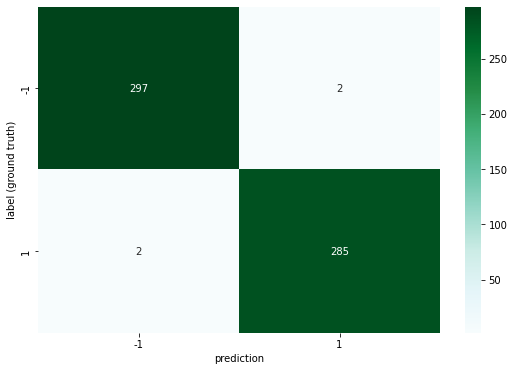

(297, 2, 2, 285)

In [ ]:
# 上採樣
from sklearn.ensemble import RandomForestClassifier
clf_over = RandomForestClassifier(random_state=random_state)
clf_over = clf_over.fit(x_train_over, y_train_over)
clf_over_pred = clf_over.predict(x_test_over)
plot_CM(y_test_over, clf_over_pred, class_name)

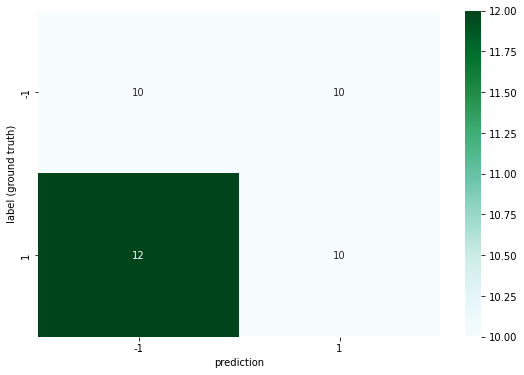

(10, 10, 12, 10)

In [ ]:
# 下採樣
clf_under = RandomForestClassifier(random_state=random_state)
clf_under = clf_under.fit(x_train_under, y_train_under)
clf_under_pred = clf_under.predict(x_test_under)
plot_CM(y_test_under, clf_under_pred, class_name)

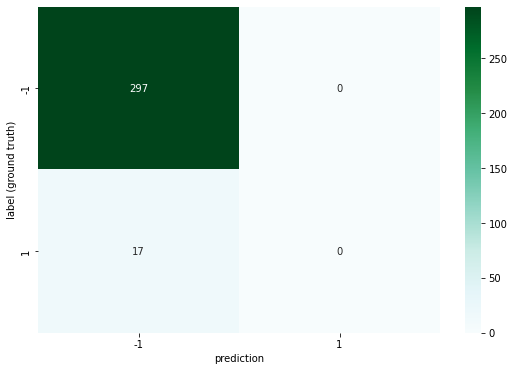

(297, 0, 17, 0)

In [ ]:
# 代價敏感學習
class_weight = {-1:1, 1:14}
clf_sens = RandomForestClassifier(random_state=random_state, class_weight=class_weight)
x_train_sens, x_test_sens, y_train_sens, y_test_sens = train_test_split(x, y, test_size = 0.2, random_state = random_state)

clf_sens = clf_sens.fit(x_train_sens, y_train_sens)
clf_sens_pred = clf_sens.predict(x_test_sens)
plot_CM(y_test_sens, clf_sens_pred, class_name)

上述的 cost 設計效果不大，因此換一組參數試試看

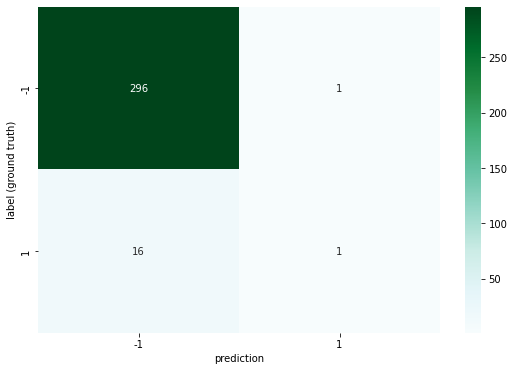

(296, 1, 16, 1)

In [ ]:
# 代價敏感學習
class_weight = {-1:1, 1:140}
clf_sens = RandomForestClassifier(random_state=random_state, class_weight=class_weight)
x_train_sens, x_test_sens, y_train_sens, y_test_sens = train_test_split(x, y, test_size = 0.2, random_state = random_state)

clf_sens = clf_sens.fit(x_train_sens, y_train_sens)
clf_sens_pred = clf_sens.predict(x_test_sens)
plot_CM(y_test_sens, clf_sens_pred, class_name)

理論上 : 

若單從理論上來看，代價敏感學習應該是較好的選擇，因為他不會損失資料及裡面的任何資料，能夠保持完整的資料集來進行訓練。上採樣的問題在於「產生的新資料是否符合原本的分布?」、而下採樣的問題在於「有許多筆資料沒有被考慮進去」，因此代價敏感學習應該是最優解

實際上 : 

實際上的情形最好還是跑過一次模型比較準確，以上述的結果來看「上採樣」的效果最佳，因此推薦使用上採樣

## (c) (10%) 對於數據多數群與少數群的比例應當調整至多少？為什麼？試透過調整生成比率 (i.e. 敏感度分析 )來看模型分類結果。 (提示：將敏感度分析以繪圖呈現兩條曲線， x軸為不同生成比例、 y軸為偽陽性率 (false positive rate)與偽陰性率 (false negative rate))

Ref: https://ithelp.ithome.com.tw/articles/10228941

Ref : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html




In [ ]:
random_state = 77
x_, y_ = SMOTE(sampling_strategy=0.2,random_state=random_state).fit_resample(x, y)
print(y_.value_counts())

-1    1463
 1     104
Name: Label, dtype: int64


In [ ]:
random_state = 77
x_train_over_bal, y_train_over_bal = SMOTE(random_state=random_state).fit_resample(x, y)
print(y_train_over_bal.value_counts())
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(x_train_over_bal, y_train_over_bal, test_size = 0.2, random_state = random_state)

In [ ]:
random_state = 77
minority_label_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
FPRs = []
FNRs = []
for ratio in minority_label_ratio:
  x_train_over_bal, y_train_over_bal = SMOTE(sampling_strategy=ratio, random_state=random_state).fit_resample(x, y)
  x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(x_train_over_bal, y_train_over_bal, test_size = 0.2, random_state = random_state)
  clf_over = RandomForestClassifier(random_state=random_state)
  clf_over = clf_over.fit(x_train_over, y_train_over)
  clf_over_pred = clf_over.predict(x_test_over)
  tn, fp, fn, tp = get_CM_Parameter(y_test_over, clf_over_pred)
  FPR = fp / (fp + tn) * 100
  FNR = fn / (tp + fn) * 100

  FPRs.append(FPR)
  FNRs.append(FNR)
print(FPRs)
print(FNRs)

[0.0, 0.0, 0.0, 0.0, 0.6802721088435374, 0.33222591362126247, 0.30303030303030304, 0.6389776357827476, 0.6688963210702341, 0.6688963210702341]
[90.0, 38.983050847457626, 23.076923076923077, 14.953271028037381, 9.655172413793103, 2.3952095808383236, 2.380952380952381, 1.8691588785046727, 0.7782101167315175, 0.6968641114982579]


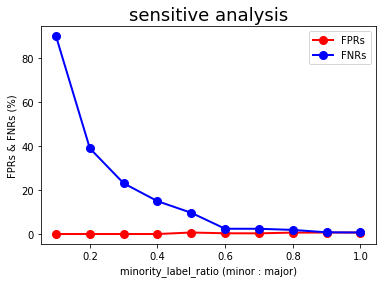

In [ ]:
plt.plot(minority_label_ratio, FPRs, color='red', linestyle="-", linewidth="2", markersize="16", marker=".", label="FPRs")
plt.plot(minority_label_ratio, FNRs, color='blue', linestyle="-", linewidth="2", markersize="16", marker=".", label="FNRs")

plt.xlabel('minority_label_ratio (minor : major)', fontsize="10") 
plt.ylabel('FPRs & FNRs (%)', fontsize="10") 
plt.title('sensitive analysis', fontsize="18") 

plt.legend()
plt.show()

此敏感度分析 X 軸代表「少數 : 多數」的比例；Y 軸代表「FP Rate(%)、FN Rate (%)」


由上圖的敏感度分析可以看出 FP rate 總是維持十分低的 % 數，表現良好；但 FN Rate 則有明顯的不同，當少數樣本的比例過低 (Ex: 0.1 ~ 0.2)，FN Rate 非常的高 (40%~90%)，這代表 FN (也就是預測為不良品，但實際為良品) 的次數非常高。雖然 FN 的後果沒有比 FP (預設良品，實際為不良品，出貨就慘了) 還嚴重，但因為我們的 FP 一直都維持相當不錯的水準，所以我建議直接將樣本數拉到 0.6:1 ~ 1:1 (少數:多數)，讓他能同時保有較低的 FP Rate、FN Rate。

## (d) (10%) 試說明特徵挑選步驟應於數據平衡 前 或 後 ，這對預測結果有何影響

特徵挑選應於數據平衡之「前」，理由如下: 

我們要找出的「重要特徵」，應是基於原始數據的重要特徵，假如使用了如上採樣這種方式產生出了額外的資料，抓到的「重要特徵」可能就不是真正的重要特徵，畢竟上採樣的資料無法保證跟原始資料有相同的特性。用下採樣的情形雷同，我們可能因為捨棄一些資料，而失去了一些重要的特徵。

這對預測結果有何影響?

假如上採樣的效果不佳，可能會讓預測結果整個被「產生的假資料」給帶著走，使之成效不佳；下採樣的情形可能直接忽視了某接重要特徵，導致無法準確預測。



# 2. (30%) Programming Questions

## (a) (0%) Learn Genetic Algorithm (GA) from the internet video https://www.youtube.com/watch?v=kHyNqSnzP8Y or https://www.youtube.com/watch?v=Fdk7ZKJHFcI .

## (b) (15%) Develop Tabu Search (TS) algorithm to solve the problem. Show your design and the “result”.

In [ ]:
def cal_weighted_tardiness(job_seq, p, d, w):

  flow_time = 0
  w_tardiness = 0
  for job in job_seq:
    flow_time += p[job]
    if flow_time > d[job]: # 當 flow time > due time 時會產生 tardiness
      w_tardiness += w[job] * (flow_time - d[job]) # 把它乘以 weight 總合起來就是 weighted tardiness

  return w_tardiness

def tabu_neighborhood_swap(job_seq, tabu_list, tabu_size,  p, d, w):
  
  temp_seqs = []
  temp_tabu = []
  for i in range(len(job_seq) - 1):
    temp_seq = []
    tabu_result = (job_seq[i+1], job_seq[i]) 
    if tabu_result not in tabu_list: # 如果不在 tabu 裡面，才會去做交換的動作

      if i != 0:
        temp_seq += job_seq[0:i] + [job_seq[i+1]] + [job_seq[i]] + job_seq[i+2:]
      else:
        temp_seq += [job_seq[i+1]] + [job_seq[i]] + job_seq[i+2:]
      
      temp_tabu.append((job_seq[i], job_seq[i+1]))

      temp_seqs.append(temp_seq)
  
  best_score = 99999
  best_job_seq = []
  best_tabu = ()
  for seq, tabu in zip(temp_seqs, temp_tabu):
    temp_score = cal_weighted_tardiness(seq, p, d, w)
    if temp_score < best_score:
      best_score = temp_score
      best_job_seq = seq
      best_tabu = tabu
  
  tabu_list.append(best_tabu)

  if len(tabu_list) > tabu_size:
    tabu_list = tabu_list[1:]

  return tabu_list, best_job_seq


Ref: MDS_Lecture16_Metaheuristic_2022 PDF (P15~P20)

**針對 Tabu Algorithm 我設計了兩個 Function**

cal_weighted_tardiness() : 用來計算 weighted tardiness

tabu_neighborhood_swap() : 用來實作 tabu neighborhood searching
scheme


**設計想法如下 :**

cal_weighted_tardiness() :

* `if flow_time > d[job]:` # 當 flow time > due time 時會產生 tardiness
* `w_tardiness += w[job] * (flow_time - d[job])` # 把它乘以 weight 總合起來就是 weighted tardiness

tabu_neighborhood_swap() :
* `if tabu_result not in tabu_list:` # 如果不在 tabu 裡面，才會去做交換的動作
* 鄰近交換
```
      if i != 0:
        temp_seq += job_seq[0:i] + [job_seq[i+1]] + [job_seq[i]] + job_seq[i+2:]
      else:
        temp_seq += [job_seq[i+1]] + [job_seq[i]] + job_seq[i+2:]
      
      temp_tabu.append((i, i+1))

      temp_seqs.append(temp_seq)
```
* 儲存最佳結果，並檢查是否有超過 tabu size
```
  best_score = 99999
  best_job_seq = []
  best_tabu = ()
  for seq, tabu in zip(temp_seqs, temp_tabu):
    temp_score = cal_weighted_tardiness(seq, p, d, w)
    if temp_score < best_score:
      best_score = temp_score
      best_job_seq = seq
      best_tabu = tabu
  
  tabu_list.append(best_tabu)

  if len(tabu_list) > tabu_size:
    tabu_list = tabu_list[1:]
```






In [ ]:
import numpy as np

p = [10,10,13,4,9,4,8,15,7,1,9,3,15,9,11,6,5,14,18,3]
d = [50,38,49,12,20,105,73,45,6,64,15,6,92,43,78,21,15,50,150,99]
w = [10,5,1,5,10,1,5,10,5,1,5,10,10,5,1,10,5,5,1,5]

tabu_size = 4
tabu_list = []
init_population = list(np.random.permutation(len(p)))

epoch = 1000

for e in range(epoch):
  if e == 0:
    tabu_list, best_job_seq = tabu_neighborhood_swap(init_population, tabu_list, tabu_size,  p, d, w)
  else:
    tabu_list, best_job_seq = tabu_neighborhood_swap(best_job_seq, tabu_list, tabu_size,  p, d, w)

  print("Epoch:", e+1 ,"Score:", cal_weighted_tardiness(best_job_seq, p, d, w))


Epoch: 1 Score: 5662
Epoch: 2 Score: 5615
Epoch: 3 Score: 5570
Epoch: 4 Score: 5520
Epoch: 5 Score: 5475
Epoch: 6 Score: 5420
Epoch: 7 Score: 5360
Epoch: 8 Score: 5310
Epoch: 9 Score: 5225
Epoch: 10 Score: 5155
Epoch: 11 Score: 5118
Epoch: 12 Score: 5011
Epoch: 13 Score: 4946
Epoch: 14 Score: 4891
Epoch: 15 Score: 4771
Epoch: 16 Score: 4696
Epoch: 17 Score: 4666
Epoch: 18 Score: 4641
Epoch: 19 Score: 4606
Epoch: 20 Score: 4536
Epoch: 21 Score: 4406
Epoch: 22 Score: 4361
Epoch: 23 Score: 4303
Epoch: 24 Score: 4188
Epoch: 25 Score: 4168
Epoch: 26 Score: 3988
Epoch: 27 Score: 3898
Epoch: 28 Score: 3718
Epoch: 29 Score: 3628
Epoch: 30 Score: 3538
Epoch: 31 Score: 3508
Epoch: 32 Score: 3438
Epoch: 33 Score: 3423
Epoch: 34 Score: 3408
Epoch: 35 Score: 3396
Epoch: 36 Score: 3382
Epoch: 37 Score: 3306
Epoch: 38 Score: 3296
Epoch: 39 Score: 3289
Epoch: 40 Score: 3162
Epoch: 41 Score: 3042
Epoch: 42 Score: 2986
Epoch: 43 Score: 2976
Epoch: 44 Score: 2901
Epoch: 45 Score: 2781
Epoch: 46 Score: 26

TS Parameter settings


* tabu_size = 4
* tabu_list = []
* init_population = list(np.random.permutation(len(p)))
* epoch = 1000




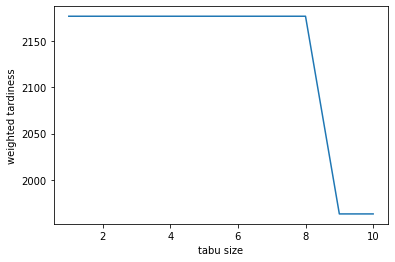

In [ ]:
### sensitive analysis ###
import numpy as np

p = [10,10,13,4,9,4,8,15,7,1,9,3,15,9,11,6,5,14,18,3]
d = [50,38,49,12,20,105,73,45,6,64,15,6,92,43,78,21,15,50,150,99]
w = [10,5,1,5,10,1,5,10,5,1,5,10,10,5,1,10,5,5,1,5]

tabu_sizes = [1,2,3,4,5,6,7,8,9,10]
init_population = list(np.random.permutation(len(p)))

epoch = 1000
best_score_list = []
for tabu_size in tabu_sizes:

  tabu_list = []
  best_score = 99999
  for e in range(epoch):

    if e == 0:
      tabu_list, best_job_seq = tabu_neighborhood_swap(init_population, tabu_list, tabu_size,  p, d, w)
    else:
      tabu_list, best_job_seq = tabu_neighborhood_swap(best_job_seq, tabu_list, tabu_size,  p, d, w)

    if cal_weighted_tardiness(best_job_seq, p, d, w) < best_score:
      
      best_score = cal_weighted_tardiness(best_job_seq, p, d, w)

    # print("Epoch:", e+1, cal_weighted_tardiness(best_job_seq, p, d, w))
  best_score_list.append(best_score)

plt.plot(tabu_sizes, best_score_list)
plt.xlabel("tabu size")
plt.ylabel("weighted tardiness")
plt.show()

在此我設計一個敏感度分析的實驗，我想探討 「tabu size」 與 「weighted tardiness」 的關係 (X軸 = tabu size、Y軸 = weighted tardiness

由上圖可以看出，
* 在 tabu size < 9 時，weighted tardiness最終都達到一樣的數值(2200左右)，但是
* 在 tabu size >= 9 之後，weighted tardiness 又更進一步的下降 (低於2000)。

此現象可能是因為當 tabu size 越大時，其**「探索」未知可能性的能力就較高** (Ref: 教科書PDF=P15)，使之有機會嘗試到更佳的解，因此在 tabu size >= 9 時效果比 tabu size < 9 還要好 

## (c) (15%) Develop Genetic Algorithm (GA) to solve the problem. Show your design and the “result”.

Ref: MDS_Lecture16_Metaheuristic_2022 PDF (P71~P72)



In [ ]:
def cal_weighted_tardiness(job_seq, p, d, w):

  flow_time = 0
  w_tardiness = 0
  for job in job_seq:
    flow_time += p[job]
    if flow_time > d[job]: # 當 flow time > due time 時會產生 tardiness
      w_tardiness += w[job] * (flow_time - d[job]) # 把它乘以 weight 總合起來就是 weighted tardiness

  return w_tardiness

def cross_over(parent_1, parent_2, crossover_index):
  ### PMX 部分映射交配 ###

  for index in crossover_index:
    if parent_1[index] != parent_2[index]: # 當交配時發現數值不同
      
      index_1 = parent_1.index(parent_2[index]) 
      index_2 = index

      parent_1[index_1], parent_1[index_2] = parent_1[index_2], parent_1[index_1] # 交換兩邊的數值
  
  child = parent_1

  return child

def mutation(parent, mutation_index, mutation_num):
  ### 置換突變 ###
  parent[mutation_index:mutation_index + mutation_num], parent[mutation_index + mutation_num: mutation_index + 2*mutation_num] = parent[mutation_index + mutation_num: mutation_index + 2*mutation_num], parent[mutation_index:mutation_index + mutation_num]
  child = parent
  return child

Ref: MDS_Lecture16_Metaheuristic_2022 PDF (P71~P72)

**針對 Genetic Algorithm (GA) 我設計了三個 Function** 
* cal_weighted_tardiness() : 用來計算 weighted tardiness
* cross_over() : 用來進行 cross over
* mutation() : 用來進行 mutation

**設計想法如下 :**

cal_weighted_tardiness() :
*     `if flow_time > d[job]:` # 當 flow time > due time 時會產生 tardiness
*     `w_tardiness += w[job] * (flow_time - d[job])` # 把它乘以 weight 總合起來就是 weighted tardiness

cross_over(): 
* 在此使用 PMX (部分映射交配)
* `if parent_1[index] != parent_2[index]:` # 當交配時發現兩個母代數值不同
* `parent_1[index_1], parent_1[index_2] = parent_1[index_2], parent_1[index_1]` # 在第一母代進行數值上的交換
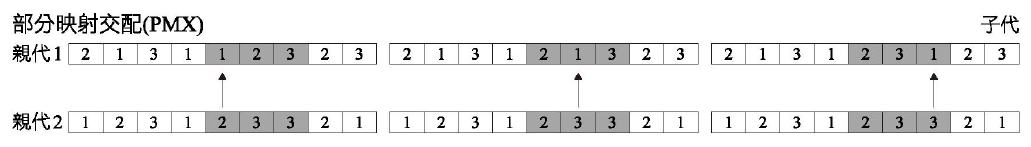

mutation():
* 非常單純，找到一個起始點後將後續的基因進行置換
* `parent[mutation_index:mutation_index + mutation_num], parent[mutation_index + mutation_num: mutation_index + 2*mutation_num] = parent[mutation_index + mutation_num: mutation_index + 2*mutation_num], parent[mutation_index:mutation_index + mutation_num]`
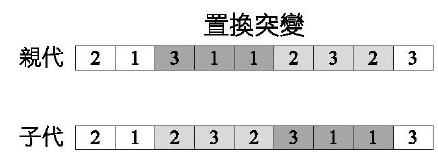


In [ ]:
import numpy as np

p = [10,10,13,4,9,4,8,15,7,1,9,3,15,9,11,6,5,14,18,3]
d = [50,38,49,12,20,105,73,45,6,64,15,6,92,43,78,21,15,50,150,99]
w = [10,5,1,5,10,1,5,10,5,1,5,10,10,5,1,10,5,5,1,5]

# GA Parameter

crossover_rate = 0.5
crossover_num = len(p) // 2

mutation_rate = 0.2
mutation_num = len(p) // 5

population_size = 10
population = []
population_score = {}
epoch = 1000

### init population ###
for i in range(population_size):
  popu_item = list(np.random.permutation(len(p)))
  population.append(popu_item)
  population_score[tuple(popu_item)] = cal_weighted_tardiness(popu_item, p, d, w)

print("Init population :")
for key in population_score:
  print(key, ":", population_score[key])

Init population :
(11, 6, 0, 19, 18, 10, 2, 16, 9, 4, 12, 1, 7, 17, 5, 3, 15, 13, 8, 14) : 5949
(15, 19, 11, 1, 14, 5, 12, 9, 8, 17, 0, 10, 18, 2, 4, 3, 13, 7, 6, 16) : 5960
(16, 3, 12, 13, 1, 11, 2, 9, 8, 14, 19, 15, 0, 10, 18, 7, 6, 4, 17, 5) : 5664
(14, 4, 3, 6, 11, 8, 9, 0, 16, 18, 19, 1, 10, 5, 2, 12, 17, 13, 15, 7) : 5581
(11, 7, 17, 12, 5, 16, 14, 18, 2, 3, 9, 13, 4, 19, 15, 8, 6, 0, 10, 1) : 6803
(1, 9, 19, 6, 15, 0, 5, 11, 4, 3, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 4063
(13, 2, 18, 9, 10, 16, 3, 11, 19, 5, 1, 6, 17, 8, 15, 7, 4, 12, 0, 14) : 6996
(0, 8, 4, 14, 17, 12, 16, 7, 5, 13, 11, 9, 10, 2, 1, 3, 18, 6, 15, 19) : 6112
(17, 11, 0, 12, 18, 19, 8, 1, 16, 14, 3, 13, 9, 10, 4, 6, 2, 15, 5, 7) : 6523
(13, 2, 19, 14, 17, 10, 18, 3, 1, 6, 7, 16, 4, 15, 8, 11, 0, 5, 9, 12) : 8443


設定一些 GA 的 Parameter，並初始化 population

GA Parameter
* crossover_rate = 0.5
* crossover_num = len(p) // 2
* mutation_rate = 0.2
* mutation_num = len(p) // 5
* population_size = 10
* population = []
* population_score = {}
* epoch = 1000 

In [ ]:
best_score = 999999
best_seq = ()

### GA algorithm ###
for e in range(epoch):

  for index in range(population_size//2):
    parent_1 = population[2*index]
    parent_2 = population[2*index + 1]

    ### crossover ###
    if crossover_rate > np.random.rand():
      crossover_index = np.random.choice([i for i in range(len(p))], crossover_num, replace=False)
      crossover_child = cross_over(parent_1, parent_2, crossover_index)

      ### mutation ###
      if mutation_rate > np.random.rand():
        mutation_index = np.random.randint(0, len(p) - 2*mutation_num)
        mutation_child = mutation(crossover_child, mutation_index, mutation_num)

        ### selection ###
        child_score = cal_weighted_tardiness(mutation_child, p, d, w)

        popu_max_score = 0
        max_key = []

        ### 找到目前 population 中最差的元素 ###
        for key in population_score:
          if population_score[key] > popu_max_score:
            popu_max_score = population_score[key]
            max_key = key

        ### 替換掉 population 中最差的一個元素 ###
        if child_score < popu_max_score and tuple(mutation_child) not in population_score: 
          population_score.pop(max_key)
          population_score[tuple(mutation_child)] = child_score

      else:
        child_score = cal_weighted_tardiness(crossover_child, p, d, w)

        popu_max_score = 0
        max_key = []
        ### 找到目前 population 中最差的元素 ###
        for key in population_score:
          if population_score[key] > popu_max_score:
            popu_max_score = population_score[key]
            max_key = key

        ### 替換掉 population 中最差的一個元素 ###
        if child_score < popu_max_score and tuple(crossover_child) not in population_score: 
          population_score.pop(max_key)
          population_score[tuple(crossover_child)] = child_score
    

  print("Epoch:", e+1)
  for key in population_score:
    print(key, ":", population_score[key])
    if population_score[key] < best_score:
      best_score = population_score[key]
      best_seq = key

print("Best sequence:", best_seq)
print("Best socre:", best_score)

串流輸出內容已截斷至最後 5000 行。
(1, 9, 19, 11, 15, 3, 5, 6, 4, 0, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3598
(1, 9, 19, 6, 15, 3, 5, 11, 4, 0, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3893
(1, 9, 5, 6, 15, 3, 19, 11, 4, 0, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3908
(1, 9, 5, 11, 15, 0, 19, 6, 4, 3, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3753
Epoch: 547
(1, 9, 5, 11, 4, 3, 19, 6, 15, 0, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3668
(1, 9, 19, 6, 15, 0, 5, 11, 4, 3, 12, 13, 10, 16, 7, 17, 8, 14, 18, 2) : 3876
(1, 9, 19, 6, 15, 0, 5, 11, 4, 3, 7, 13, 8, 16, 12, 17, 10, 14, 18, 2) : 3636
(1, 9, 19, 11, 4, 3, 7, 6, 15, 0, 5, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3583
(15, 0, 5, 11, 1, 9, 19, 6, 4, 3, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3773
(1, 9, 19, 11, 15, 0, 5, 6, 4, 3, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3733
(1, 9, 19, 11, 15, 3, 5, 6, 4, 0, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3598
(1, 9, 19, 6, 15, 3, 5, 11, 4, 0, 7, 17, 8, 14, 12, 13, 10, 16, 18, 2) : 3893
(1, 9, 5, 6, 15, 3, 19, 11, 4, 0

上述是我設計的 GA Algorithm 可以分成 3 個部分來看 (前兩個部分就是前面設計的 Function，在此不多贅述)

1.     ### crossover ### 
      ```
      if crossover_rate > np.random.rand():
        crossover_index = np.random.choice([i for i in range(len(p))], crossover_num, replace=False)

      crossover_child = cross_over(parent_1, parent_2, crossover_index)
      ```


2.       ### mutation ###
        ```
        if mutation_rate > np.random.rand():
          mutation_index = np.random.randint(0, len(p) - 2*mutation_num)
        
        mutation_child = mutation(crossover_child, mutation_index, mutation_num)
        ```

3.         ### selection (用來決定如何更新 population)###
        ``` 
        child_score = cal_weighted_tardiness(mutation_child, p, d, w)
        popu_max_score = 0
        max_key = []

        ## [找到目前 population 中最差的元素] : ##
        for key in population_score:
          if population_score[key] > popu_max_score:
            popu_max_score = population_score[key]
            max_key = key

        ## [替換掉 population 中最差的一個元素]: ##
        
        if child_score < popu_max_score and tuple(mutation_child) not in population_score: 
            population_score.pop(max_key)
            population_score[tuple(mutation_child)] = child_score
        ```


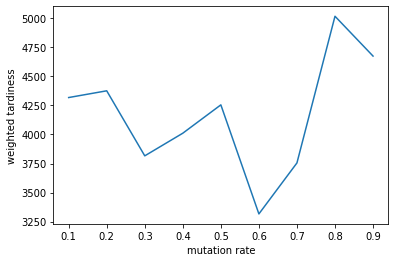

In [ ]:
### sensitivity analysis. ###
import numpy as np
import matplotlib.pyplot as plt

p = [10,10,13,4,9,4,8,15,7,1,9,3,15,9,11,6,5,14,18,3]
d = [50,38,49,12,20,105,73,45,6,64,15,6,92,43,78,21,15,50,150,99]
w = [10,5,1,5,10,1,5,10,5,1,5,10,10,5,1,10,5,5,1,5]

# GA Parameter

crossover_rate = 0.5
crossover_num = len(p) // 2

mutation_rates = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
mutation_num = len(p) // 5

epoch = 1000

best_score_list = []

### GA algorithm ###

for mutation_rate in mutation_rates:

  population_size = 10
  population = []
  population_score = {}
  ### init population ###
  for i in range(population_size):
    popu_item = list(np.random.permutation(len(p)))
    population.append(popu_item)
    population_score[tuple(popu_item)] = cal_weighted_tardiness(popu_item, p, d, w)

  best_score = 999999
  best_seq = ()
  for e in range(epoch):

    for index in range(population_size//2):
      parent_1 = population[2*index]
      parent_2 = population[2*index + 1]

      ### crossover ###
      if crossover_rate > np.random.rand():
        crossover_index = np.random.choice([i for i in range(len(p))], crossover_num, replace=False)
        crossover_child = cross_over(parent_1, parent_2, crossover_index)

        ### mutation ###
        if mutation_rate > np.random.rand():
          mutation_index = np.random.randint(0, len(p) - 2*mutation_num)
          mutation_child = mutation(crossover_child, mutation_index, mutation_num)

          ### selection ###
          child_score = cal_weighted_tardiness(mutation_child, p, d, w)

          popu_max_score = 0
          max_key = []

          ### 找到目前 population 中最差的元素 ###
          for key in population_score:
            if population_score[key] > popu_max_score:
              popu_max_score = population_score[key]
              max_key = key

          ### 替換掉 population 中最差的一個元素 ###
          if child_score < popu_max_score and tuple(mutation_child) not in population_score: 
            population_score.pop(max_key)
            population_score[tuple(mutation_child)] = child_score

        else:
          child_score = cal_weighted_tardiness(crossover_child, p, d, w)

          popu_max_score = 0
          max_key = []
          ### 找到目前 population 中最差的元素 ###
          for key in population_score:
            if population_score[key] > popu_max_score:
              popu_max_score = population_score[key]
              max_key = key

          ### 替換掉 population 中最差的一個元素 ###
          if child_score < popu_max_score and tuple(crossover_child) not in population_score: 
            population_score.pop(max_key)
            population_score[tuple(crossover_child)] = child_score
  
  for key in population_score:
    # print(key, ":", population_score[key])
    if population_score[key] < best_score:
      best_score = population_score[key]
      best_seq = key
  best_score_list.append(best_score)

plt.plot(mutation_rates, best_score_list)
plt.xlabel("mutation rate")
plt.ylabel("weighted tardiness")
plt.show()

在此我設計一個實驗來進行敏感度分析，我想探討「突變機率」與「weighted tardiness」的關聯性

上述 X 軸為 「突變機率」、Y軸為「weighted tardiness」

可以觀察出，雖然在 0.6 時有最高的分數，但**整體來說沒有一定的上升/下降趨勢**，所以突變機率與最終分數可能沒有直接的關聯性

# 3. (30%) Markov Decision Process

## (a) (5%) 試根據題目繪製轉移機率圖 (transition probability

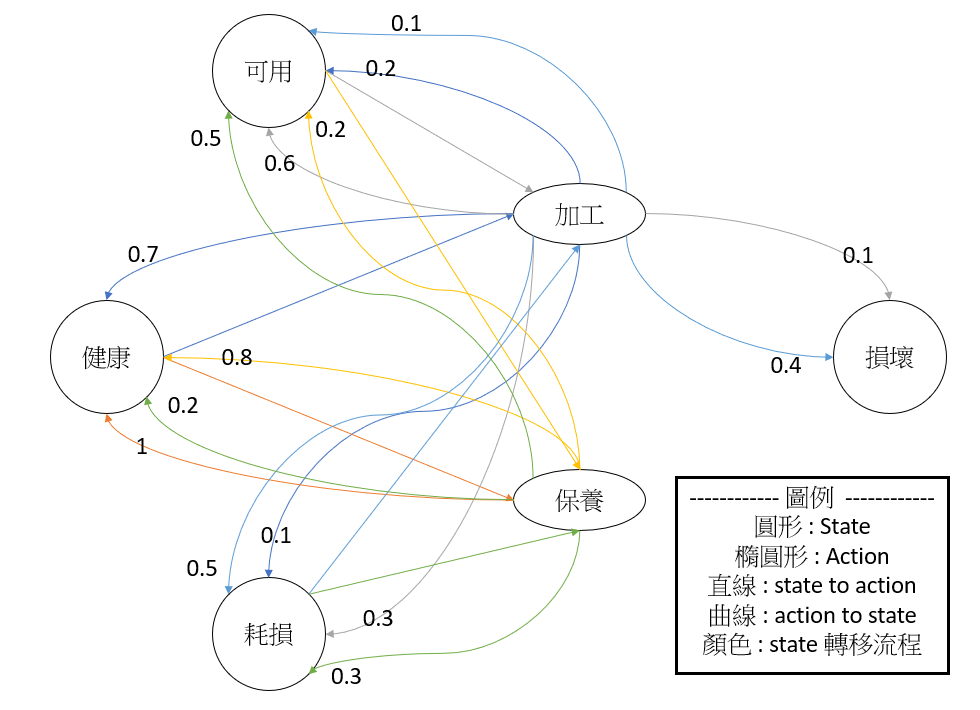

## (b) (10%) 使用價值迭代來決定最佳策略以及各個狀態的價值；

Ref : https://towardsdatascience.com/implement-value-iteration-in-python-a-minimal-working-example-f638907f3437



In [ ]:

actions = (0, 1)  # actions (0=加工, 1=保養)
states = (0, 1, 2, 3)  # states (0=健康, 1=可用, 2=耗損, 3=損壞)
rewards = [6, 3, 1, -15]  # (6=健康, 3=可用, 1=耗損, -15=損壞)

gamma = 1  # discount factor # 題目說沒有折損因子，因此 gamma = 1

# 機率轉移矩陣
probs = [
    [[0.7, 1.0], [0.2, 0.0], [0.1, 0.0], [0.0, 0.0]], # 健康狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.8], [0.6, 0.2], [0.3, 0.0], [0.1, 0.0]], # 可用狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.2], [0.1, 0.5], [0.5, 0.3], [0.4, 0.0]], # 耗損狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], # 吸收狀態，所有機率皆為0
]


# 設定最大迭代次數 # 因為不一定可以在預期的 step 內收斂
max_iter = 100000  
delta = 1e-40  
V = [0, 0, 0, 0]  
pi = [None, None, None, None]  


for i in range(max_iter):
    max_diff = 0  
    V_new = [0, 0, 0, 0]  
    
    for s in states:
        max_val = 0
        for a in actions:

            # 計算 V
            val = rewards[s]  # 當前 reward
            for s_next in states:
                val += probs[s][s_next][a] * (
                    gamma * V[s_next]
                )  # 這裡 gamma = 1，所以其實沒有折損，只是這樣寫公式上比較完整

            
            max_val = max(max_val, val)

            # 更新 pi
            if V[s] < val:
                pi[s] = actions[a]  

        V_new[s] = max_val  
    
        
        max_diff = max(max_diff, abs(V[s] - V_new[s]))

    # print("Epoch:", i, "V_new:", V_new, "pi:", pi)
    
    V = V_new

    # 提前終止條件
    if max_diff < delta:
        break

In [ ]:
print("V:",V)
print("pi:", pi)

V: [600000.0, 599996.25, 599990.1785714285, 0]
pi: [1, 1, 1, None]


## (c) (10%) 使用策略迭代來決定最佳策略以及各個狀態的價值，假設初始策略為在所有狀態皆採取行動 「加工」

Ref: https://gist.github.com/woutervanheeswijk/4504c87d00a05c4be3211258a4862bb8


In [ ]:

actions = (0, 1)  # actions (0=加工, 1=保養)
states = (0, 1, 2, 3)  # states (0=健康, 1=可用, 2=耗損, 3=損壞)
rewards = [6, 3, 1, -15]  # (6=健康, 3=可用, 1=耗損, -15=損壞)

gamma = 1  # discount factor # 題目說沒有折損因子，因此 gamma = 1

# 機率轉移矩陣
probs = [
    [[0.7, 1.0], [0.2, 0.0], [0.1, 0.0], [0.0, 0.0]], # 健康狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.8], [0.6, 0.2], [0.3, 0.0], [0.1, 0.0]], # 可用狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.2], [0.1, 0.5], [0.5, 0.3], [0.4, 0.0]], # 耗損狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], # 吸收狀態，所有機率皆為0
]

delta = 10

# 設定最大迭代次數 # 因為不一定可以在預期的 step 內收斂
max_policy_iter = 10000  
max_value_iter = 10000  
pi = [0 for s in states] # 初始策略皆為「加工」
V = [0 for s in states]

for i in range(max_policy_iter):
    print("Epoch:", i+1, "V:", V)
    optimal_policy_found = True

    # 策略評估 (計算V)
    for j in range(max_value_iter):

        max_diff = 0  
        V_new = [0, 0, 0, 0, 0]  
        for s in states:
            
            # 計算 V
            val = rewards[s]  # 當前 reward
            for s_next in states:
                val += probs[s][s_next][pi[s]] * (
                        gamma * V[s_next] 
                )  # 這裡 gamma = 1，所以其實沒有折損，只是這樣寫公式上比較完整

            max_diff = max(max_diff, abs(val - V[s]))
            
            V[s] = val  # 更新 V

        # 提前終止條件
        if max_diff < delta:
            break

    # 策略改進 (改進pi)
    for s in states:

        val_max = V[s]
        for a in actions:
            val = rewards[s]  
            for s_next in states:
                val += probs[s][s_next][a] * (
                    gamma * V[s_next]
                )  


            if val > val_max and pi[s] != a:
                pi[s] = a
                val_max = val
                optimal_policy_found = False

    if optimal_policy_found:
        break

串流輸出內容已截斷至最後 5000 行。
Epoch: 5001 V: [31222.22542640608, 31224.45522562801, 31222.614014699247, -15.0]
Epoch: 5002 V: [31228.71024507978, 31230.859241189428, 31228.955874020445, -15.0]
Epoch: 5003 V: [31234.71024507978, 31236.94004430171, 31235.098833372944, -15.0]
Epoch: 5004 V: [31241.195063753483, 31243.34405986313, 31241.440692694145, -15.0]
Epoch: 5005 V: [31247.195063753483, 31249.424862975415, 31247.583652046647, -15.0]
Epoch: 5006 V: [31253.679882427183, 31255.82887853683, 31253.925511367845, -15.0]
Epoch: 5007 V: [31259.679882427183, 31261.909681649115, 31260.068470720347, -15.0]
Epoch: 5008 V: [31266.164701100886, 31268.313697210535, 31266.410330041545, -15.0]
Epoch: 5009 V: [31272.164701100886, 31274.39450032282, 31272.55328939405, -15.0]
Epoch: 5010 V: [31278.649519774586, 31280.798515884235, 31278.89514871525, -15.0]
Epoch: 5011 V: [31284.649519774586, 31286.879318996518, 31285.03810806775, -15.0]
Epoch: 5012 V: [31291.13433844829, 31293.28333455794, 31291.37996738895, -15.

In [ ]:
print("Init pi:", [0 for s in states])
print("V:",V)
print("pi:", pi)

Init pi: [0, 0, 0, 0]
V: [62434.27211065622, 62436.50190987815, 62434.660698949374, -15.0]
pi: [0, 1, 1, 0]


## (d) (5%) (d)承接 (c)的答案，如果初始策略在所有狀態皆採取行動 「保養」， 策略迭代的計算過程與結果有什麼差異？

In [ ]:

actions = (0, 1)  # actions (0=加工, 1=保養)
states = (0, 1, 2, 3)  # states (0=健康, 1=可用, 2=耗損, 3=損壞)
rewards = [6, 3, 1, -15]  # (6=健康, 3=可用, 1=耗損, -15=損壞)

gamma = 1  # discount factor # 題目說沒有折損因子，因此 gamma = 1

# 機率轉移矩陣
probs = [
    [[0.7, 1.0], [0.2, 0.0], [0.1, 0.0], [0.0, 0.0]], # 健康狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.8], [0.6, 0.2], [0.3, 0.0], [0.1, 0.0]], # 可用狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.2], [0.1, 0.5], [0.5, 0.3], [0.4, 0.0]], # 耗損狀態下採取 action (0,1) state 改變的機率，每個元素 index 對應其 state index 
    [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], # 吸收狀態，所有機率皆為0
]

delta = 10

# 設定最大迭代次數 # 因為不一定可以在預期的 step 內收斂
max_policy_iter = 10000  
max_value_iter = 10000  
pi = [1 for s in states] # 初始策略皆為「加工」
V = [0 for s in states]


for i in range(max_policy_iter):
    print("Epoch:", i+1, "V:", V)
    optimal_policy_found = True

    # 策略評估 (計算V)
    for j in range(max_value_iter):
        max_diff = 0  
        V_new = [0, 0, 0, 0, 0]  
        for s in states:

            # 計算 V
            val = rewards[s]  # 當前 reward
            for s_next in states:
                val += probs[s][s_next][pi[s]] * (
                        gamma * V[s_next] 
                )  # 這裡 gamma = 1，所以其實沒有折損，只是這樣寫公式上比較完整

            
            max_diff = max(max_diff, abs(val - V[s]))

            V[s] = val  # 更新 V
        # 提前終止條件
        if max_diff < delta:
            break

    # 策略改進 (改進pi)
    for s in states:

        val_max = V[s]
        for a in actions:
            val = rewards[s]  
            for s_next in states:
                val += probs[s][s_next][a] * (
                    gamma * V[s_next]
                )  

            if val > val_max and pi[s] != a:
                pi[s] = a
                val_max = val
                optimal_policy_found = False

    if optimal_policy_found:
        break

串流輸出內容已截斷至最後 5000 行。
Epoch: 5001 V: [31218.02365857529, 31220.17265468494, 31218.269287515956, -15.0]
Epoch: 5002 V: [31224.02365857529, 31226.253457797222, 31224.412246868455, -15.0]
Epoch: 5003 V: [31230.508477248994, 31232.657473358642, 31230.754106189655, -15.0]
Epoch: 5004 V: [31236.508477248994, 31238.738276470925, 31236.897065542158, -15.0]
Epoch: 5005 V: [31242.993295922694, 31245.142292032342, 31243.23892486336, -15.0]
Epoch: 5006 V: [31248.993295922694, 31251.223095144625, 31249.381884215858, -15.0]
Epoch: 5007 V: [31255.478114596397, 31257.627110706046, 31255.723743537063, -15.0]
Epoch: 5008 V: [31261.478114596397, 31263.70791381833, 31261.866702889565, -15.0]
Epoch: 5009 V: [31267.962933270097, 31270.111929379746, 31268.208562210762, -15.0]
Epoch: 5010 V: [31273.962933270097, 31276.19273249203, 31274.35152156326, -15.0]
Epoch: 5011 V: [31280.4477519438, 31282.59674805345, 31280.693380884462, -15.0]
Epoch: 5012 V: [31286.4477519438, 31288.677551165732, 31286.836340236965, -1

In [ ]:
print("Init pi:", [1 for s in states])
print("V:",V)
print("pi:", pi)

Init pi: [1, 1, 1, 1]
V: [62430.07034282547, 62432.219338935116, 62430.315971766126, -15.0]
pi: [1, 1, 1, 1]
